In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

In [2]:
import pandas as pd
import os
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import unix_timestamp, from_unixtime
import pyspark.sql.functions as f
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import concat, col, lit
import matplotlib.pyplot as plt

In [3]:
sc.version

'2.1.1'

In [4]:
df = spark.read.csv('./bikeshare_2018/*', header = True)
# df = spark.read.csv('/home/wyc/bikeshare_2018/Bikeshare_Ridership_2018_Q1.csv', header = True)

In [5]:
# to get the station id and station name
df_station = spark.read.csv('./station/station_coordinate.csv', header = True)
df_station = df_station.collect()

In [6]:
station_dict = {}
type(df_station)
for x in df_station:
    details = []
    station_id = x['station_id'][:4]
    details.append(x['name'])
    details.append(x['lat'])
    details.append(x['lon'])
    station_dict[station_id] = details
    
# print(station_dict)

In [7]:
df = df.withColumn("trip_duration_seconds", df["trip_duration_seconds"].cast(IntegerType()))
df.printSchema()
df.take(3)

root
 |-- trip_id: string (nullable = true)
 |-- trip_duration_seconds: integer (nullable = true)
 |-- from_station_id: string (nullable = true)
 |-- trip_start_time: string (nullable = true)
 |-- from_station_name: string (nullable = true)
 |-- trip_stop_time: string (nullable = true)
 |-- to_station_id: string (nullable = true)
 |-- to_station_name: string (nullable = true)
 |-- user_type: string (nullable = true)



[Row(trip_id='3244396', trip_duration_seconds=528, from_station_id='7254', trip_start_time='7/1/2018 0:00', from_station_name='Borden St / Bloor St W - SMART', trip_stop_time='7/1/2018 0:08', to_station_id='7140', to_station_name='Macpherson Ave / Spadina Rd', user_type='Annual Member'),
 Row(trip_id='3244398', trip_duration_seconds=570, from_station_id='7031', trip_start_time='7/1/2018 0:00', from_station_name='Jarvis St / Isabella St', trip_stop_time='7/1/2018 0:09', to_station_id='7167', to_station_name='Queen St E / George St (Moss Park)', user_type='Annual Member'),
 Row(trip_id='3244397', trip_duration_seconds=368, from_station_id='7286', trip_start_time='7/1/2018 0:00', from_station_name='Gerrard St E / Broadview - SMART', trip_stop_time='7/1/2018 0:06', to_station_id='7286', to_station_name='Gerrard St E / Broadview - SMART', user_type='Casual Member')]

In [8]:
df.count()

1922955

In [9]:
# orders of the year and total duration seconds
# 全年订单数量 和 全年订单自行车一共骑行时间

orders_year = df.count()
print("orders of the year: ", orders_year)

duration_seconds_year = df.agg({'trip_duration_seconds':'sum'}).collect()
durations_year = int(str(duration_seconds_year[0]).split('=')[1].split(')')[0])
print('total durations of the year: ',durations_year)

orders of the year:  1922955
total durations of the year:  1851759548


In [10]:
# calculate total orders of each month
# 单月的订单数量
orders_per_month = []
for i in range(1, 13):
    orders_per_month.append(df.filter(df.trip_start_time.like(str(i)+'/%/2018%')).count())
    
print(orders_per_month)

[43859, 49731, 84969, 94783, 212750, 250837, 286316, 281219, 255001, 175879, 104287, 83324]


In [11]:
# calculate total duration seconds of each month
# 单月全部订单自行车骑行时间
duration_per_month = []
for i in range(1, 13):
    duration_seconds_month = df.filter(df.trip_start_time.like(str(i)+'/%/2018%')) \
                               .agg({'trip_duration_seconds':'sum'}) \
                               .collect()
    duration_per_month.append(int(str(duration_seconds_month[0]).split('=')[1].split(')')[0]))
    
print(duration_per_month)

[28685851, 34691468, 60981432, 83557114, 247488313, 275920463, 312306290, 301728200, 245977152, 135642480, 70133599, 54647186]


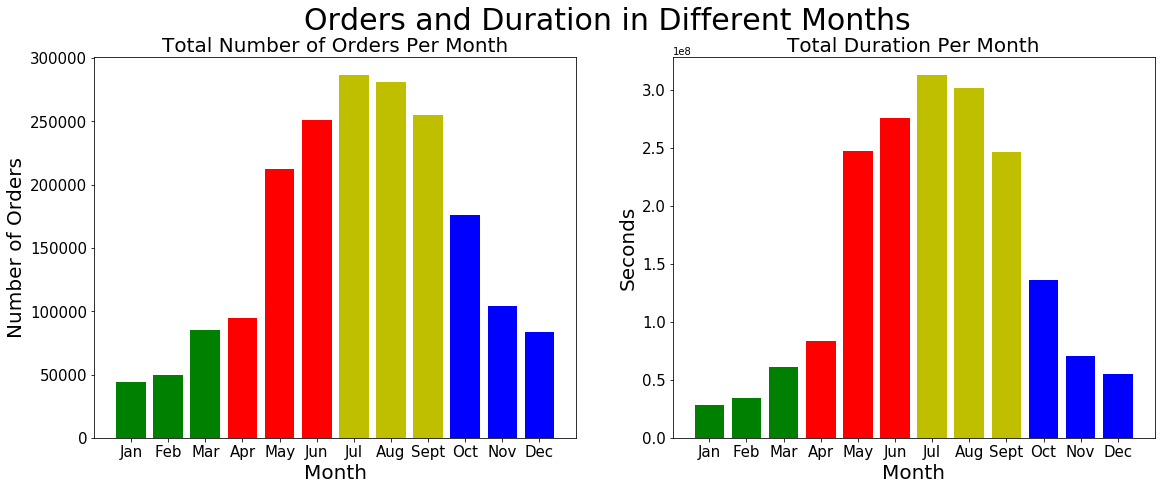

In [12]:
month_name = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

fig = plt.figure(1)
fig.suptitle('Orders and Duration in Different Months', fontsize=30)
fig.set_size_inches(19, 7, forward = True)

ax1 = plt.subplot(121)
ax1.bar(range(len(month_name)), orders_per_month, tick_label=month_name, color='gggrrryyybbb')
plt.title('Total Number of Orders Per Month', fontsize=20)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Number of Orders', fontsize=20)
plt.tick_params(axis='both', labelsize=15)

ax2 = plt.subplot(122)
plt.title('Total Duration Per Month', fontsize=20)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Seconds', fontsize=20)
plt.tick_params(axis='both', labelsize=15)
ax2.bar(range(len(month_name)), duration_per_month, tick_label=month_name, color='gggrrryyybbb')
# plt.savefig("1.png")
plt.show()

In [13]:
# 平均每个订单的骑行时间，每月
duration_order_month = []

for i in range(0, 12):
    duration_order_month.append(duration_per_month[i] / orders_per_month[i])
    
print(duration_order_month)
    

[654.047082696824, 697.5823530594599, 717.6903576598525, 881.5622421742296, 1163.2823172737956, 1099.9990551633132, 1090.7748431802625, 1072.9296384668178, 964.6124995588252, 771.2261270532582, 672.5056718478813, 655.839686044837]


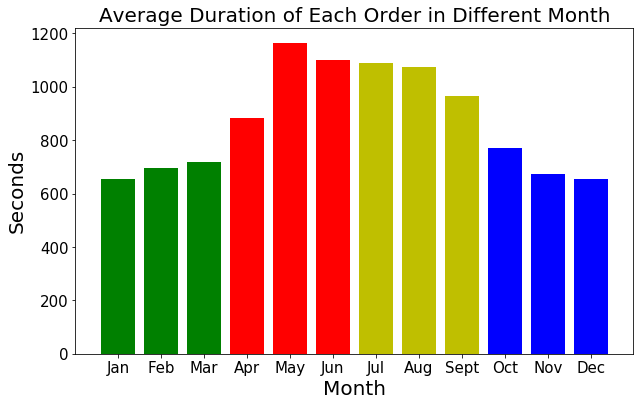

In [14]:
fig = plt.figure(2)
# fig.suptitle('title name here', fontsize=30)
fig.set_size_inches(10, 6)
ax = plt.subplot(111)
ax.bar(range(len(month_name)), duration_order_month, tick_label=month_name, color='gggrrryyybbb')
plt.title('Average Duration of Each Order in Different Month', fontsize=20)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Seconds', fontsize=20)
plt.tick_params(axis='both', labelsize=15)
# plt.savefig("2.png")
plt.show()

In [15]:
# calculate total orders of each hour
# 统计全年不同时段的订单数量
orders_per_clock = []
for i in range(0, 24):
    orders_per_clock.append(df.filter(df.trip_start_time.like('% '+str(i)+':%')).count())
    
print(orders_per_clock)

[19110, 12022, 8757, 3919, 3211, 7722, 22523, 63998, 172624, 119650, 72687, 82500, 102228, 104947, 101592, 114497, 159979, 221865, 169083, 119706, 89238, 67680, 49150, 34267]


In [16]:
# calculate total duration seconds of each hour
# 统计全年不同时段订单一共骑行时间
duration_per_clock = []
for i in range(0, 24):
    duration_seconds_clock = df.filter(df.trip_start_time.like('% '+str(i)+':%'))     .agg({'trip_duration_seconds':'sum'}).collect()
    duration_per_clock.append(int(str(duration_seconds_clock[0]).split('=')[1].split(')')[0]))
    
print(duration_per_clock)

[17737889, 11662020, 8914925, 3884363, 3040654, 5827523, 15740229, 46574737, 130130129, 90755608, 72381012, 93271269, 111356957, 120835726, 122831579, 131756760, 160019002, 206634604, 160119406, 116796956, 84834947, 61528136, 43844160, 31280957]


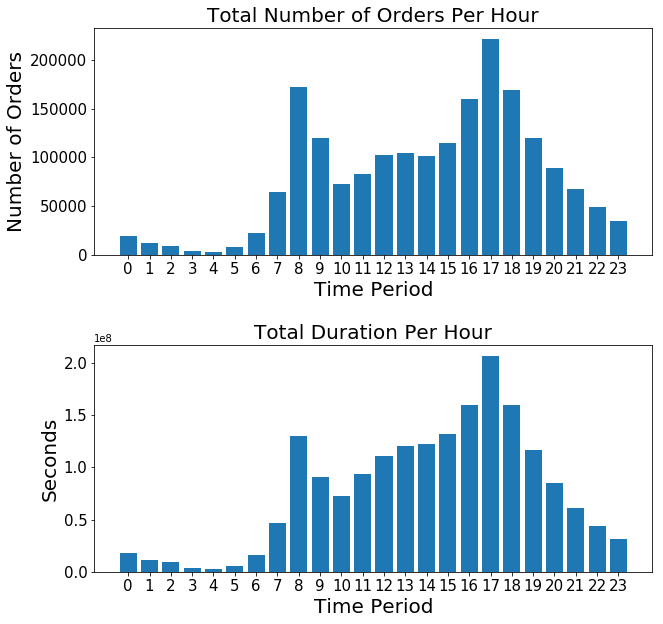

In [17]:
hour_name = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', \
             '10', '11', '12', '13', '14', '15', '16', '17', \
            '18', '19', '20', '21', '22', '23']

fig = plt.figure(3)
# fig.suptitle('title name here', fontsize=30)
fig.set_size_inches(10, 10, forward = True)

ax1 = plt.subplot(211)
ax1.bar(range(len(hour_name)), orders_per_clock, tick_label=hour_name)
plt.title('Total Number of Orders Per Hour', fontsize=20)
plt.xlabel('Time Period', fontsize=20)
plt.ylabel('Number of Orders', fontsize=20)
plt.tick_params(axis='both', labelsize=15)

plt.subplots_adjust(hspace = 0.4)

ax2 = plt.subplot(212)
plt.title('Total Duration Per Hour', fontsize=20)
plt.xlabel('Time Period', fontsize=20)
plt.ylabel('Seconds', fontsize=20)
plt.tick_params(axis='both', labelsize=15)
ax2.bar(range(len(hour_name)), duration_per_clock, tick_label=hour_name)
# plt.savefig("3.png")
plt.show()

In [18]:
# 不同时段内，平均每单骑行时间
duration_order_hour = []

for i in range(0, 24):
    duration_order_hour.append(duration_per_clock[i] / orders_per_clock[i])
    
print(duration_order_hour)

[928.1993197278912, 970.0565629678922, 1018.0341441132808, 991.1617759632559, 946.94923699782, 754.6649831649831, 698.8513519513386, 727.753007906497, 753.8356717490036, 758.5090513999164, 995.7903338973957, 1130.5608363636363, 1089.2999667410104, 1151.3976197509219, 1209.0674364123158, 1150.7442116387328, 1000.2500453184481, 931.3528677348838, 946.9870182099916, 975.6984278148129, 950.6594388040969, 909.1036643026005, 892.048016276704, 912.8595149852628]


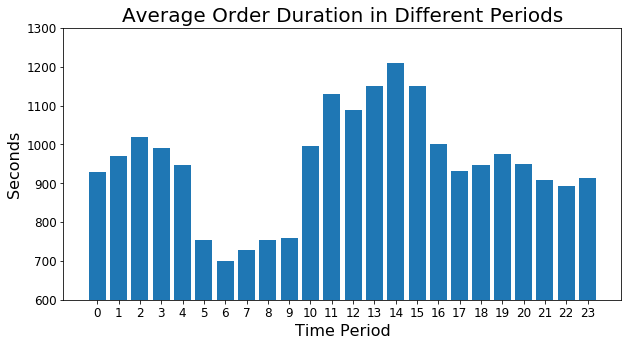

In [19]:
fig = plt.figure(4)
# fig.suptitle('title name here', fontsize=30)
ax = plt.subplot(111)
fig.set_size_inches(10, 5, forward = True)
ax.bar(range(len(hour_name)), duration_order_hour, tick_label=hour_name)
# plt.plot(range(len(hour_name)), duration_order_hour)
plt.title('Average Order Duration in Different Periods', fontsize=20)
plt.xlabel('Time Period', fontsize=16)
plt.ylabel('Seconds', fontsize=16)
plt.tick_params(axis='both', labelsize=12)
ax.set_ylim([600, 1300])
# plt.savefig("4.png")
plt.show()

In [20]:
# 2.1 from_station and to_station total orders of a year
# 全年从哪个站点出发的订单数量最多
top_10_orders_total_departing_station = []
i = 0
orders_total_from_station = df.groupby("from_station_id") \
                              .agg({"trip_id": "count"}) \
                              .sort('count(trip_id)', ascending=0) \
                              .collect()

            
for x in orders_total_from_station:
    if i > 9:
        break  
    station_id = x['from_station_id']
    orders_total = x['count(trip_id)']
    top_10_orders_total_departing_station.append([station_id, orders_total])
    i += 1
print(top_10_orders_total_departing_station)

[['7076', 24017], ['7016', 22743], ['7033', 19869], ['7030', 19184], ['7042', 19131], ['7059', 17282], ['7060', 17089], ['7038', 17054], ['7006', 16965], ['7203', 16794]]


['Bathurst St/Queens Quay(Billy Bishop Airport)', 'Bay St / College St (East Side)', 'Dundas St W / Yonge St', 'Princess St / Adelaide St E', 'Front St W / Blue Jays Way', 'Sherbourne St / Wellesley St E', 'Bay St / Wellesley St W', 'Union Station', 'Bay St / Queens Quay W (Ferry Terminal)', 'York St / Queens Quay W']
[16794, 16965, 17054, 17089, 17282, 19131, 19184, 19869, 22743, 24017]


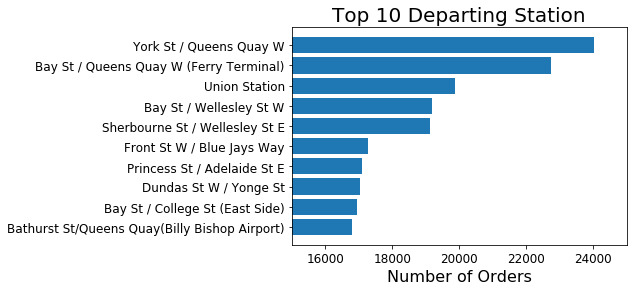

In [21]:
top_10_station_name = []
top_10_station_orders = []
for x in top_10_orders_total_departing_station:
    top_10_station_name.append(station_dict[x[0]][0])
    top_10_station_orders.append(x[1])
    
top_10_station_name = top_10_station_name[::-1]
top_10_station_orders = top_10_station_orders[::-1]

print(top_10_station_name)
print(top_10_station_orders)

fig = plt.figure(5)
ax = plt.subplot(111)
ax.set_xlim([15000, 25000])
# fig.set_size_inches(10, 5, forward = True)
ax.barh(range(len(top_10_station_name)), top_10_station_orders, tick_label=top_10_station_name)
plt.title('Top 10 Departing Station', fontsize=20)
plt.xlabel('Number of Orders', fontsize=16)
plt.tick_params(axis='both', labelsize=12)
# plt.savefig("5.png")
plt.show()

In [22]:
# 2.2 from_station and to_station total orders of a year
# 全年从哪个站点出发的订单数量最多
top_10_orders_total_arriving_station = []
i = 0
orders_total_from_station = df.groupby("to_station_id") \
                              .agg({"trip_id": "count"}) \
                              .sort('count(trip_id)', ascending=0) \
                              .collect()

            
for x in orders_total_from_station:
    if i > 9:
        break
    station_id = x['to_station_id']
    orders_total = x['count(trip_id)']
    top_10_orders_total_arriving_station.append([station_id, orders_total])
    i += 1
print(top_10_orders_total_arriving_station)

[['7076', 25754], ['7033', 25673], ['7016', 24248], ['7060', 19986], ['7038', 18540], ['7102', 18398], ['7203', 17795], ['7057', 17323], ['7059', 17243], ['7049', 16972]]


['Queen St W / Portland St', 'Front St W / Blue Jays Way', 'Simcoe St / Wellington St South', 'Bathurst St/Queens Quay(Billy Bishop Airport)', 'Nelson St / Duncan St', 'Dundas St W / Yonge St', 'Princess St / Adelaide St E', 'Bay St / Queens Quay W (Ferry Terminal)', 'Union Station', 'York St / Queens Quay W']
[16972, 17243, 17323, 17795, 18398, 18540, 19986, 24248, 25673, 25754]


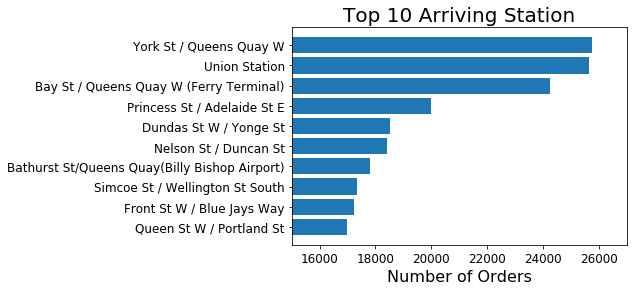

In [23]:
top_10_station_name = []
top_10_station_orders = []
for x in top_10_orders_total_arriving_station:
    top_10_station_name.append(station_dict[x[0]][0])
    top_10_station_orders.append(x[1])
    
top_10_station_name = top_10_station_name[::-1]
top_10_station_orders = top_10_station_orders[::-1]

print(top_10_station_name)
print(top_10_station_orders)

fig = plt.figure(6)
ax = plt.subplot(111)
ax.set_xlim([15000, 27000])
# fig.set_size_inches(10, 5, forward = True)
ax.barh(range(len(top_10_station_name)), top_10_station_orders, tick_label=top_10_station_name)
plt.title('Top 10 Arriving Station', fontsize=20)
plt.xlabel('Number of Orders', fontsize=16)
plt.tick_params(axis='both', labelsize=12)
# plt.savefig("6.png")
plt.show()

In [24]:
# 2.3 calculate which station was most used by user
# 统计全年从哪个站点出发的订单骑行时间最长
top_10_orders_total_duration_station = []
i = 0
duration_total_from_station = df.groupby("from_station_id") \
                              .agg({"trip_duration_seconds": "sum"}) \
                              .sort('sum(trip_duration_seconds)', ascending=0) \
                              .collect()

            
for x in duration_total_from_station:
    if i > 9:
        break
    station_id = x['from_station_id']
    duration_total = x['sum(trip_duration_seconds)']
    top_10_orders_total_duration_station.append([station_id, duration_total])
    i += 1
print(top_10_orders_total_duration_station)

[['7016', 61830593], ['7076', 39181379], ['7168', 24624348], ['7175', 23034530], ['7043', 21875397], ['7288', 19852568], ['7171', 19808799], ['7242', 19748703], ['7203', 19710711], ['7033', 18678588]]


['Union Station', 'Bathurst St/Queens Quay(Billy Bishop Airport)', 'Lakeshore Blvd W / Ontario Dr', 'Ontario Place Blvd / Lakeshore Blvd W', 'Humber Bay Shores Park West', 'Queens Quay W / Lower Simcoe St', 'HTO Park (Queens Quay W)', 'Queens Quay / Yonge St', 'York St / Queens Quay W', 'Bay St / Queens Quay W (Ferry Terminal)']
[18678588, 19710711, 19748703, 19808799, 19852568, 21875397, 23034530, 24624348, 39181379, 61830593]


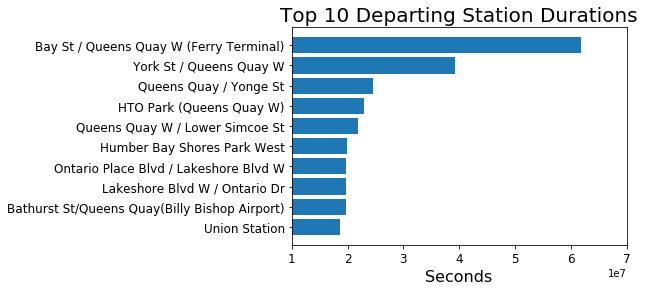

In [25]:
top_10_station_name = []
top_10_station_duration = []
for x in top_10_orders_total_duration_station:
    top_10_station_name.append(station_dict[x[0]][0])
    top_10_station_duration.append(x[1])
    
top_10_station_name = top_10_station_name[::-1]
top_10_station_duration = top_10_station_duration[::-1]

print(top_10_station_name)
print(top_10_station_duration)

fig = plt.figure(7)
ax = plt.subplot(111)
ax.set_xlim([10000000, 70000000])
# fig.set_size_inches(10, 5, forward = True)
ax.barh(range(len(top_10_station_name)), top_10_station_duration, tick_label=top_10_station_name)
plt.title('Top 10 Departing Station Durations', fontsize=20)
plt.xlabel('Seconds', fontsize=16)
plt.tick_params(axis='both', labelsize=12)
# plt.savefig("7.png")
plt.show()

In [26]:
# 统计全年到哪个站点的订单骑行时间最长
top_10_orders_total_duration_station = []
i = 0
duration_total_to_station = df.groupby("to_station_id") \
                              .agg({"trip_duration_seconds": "sum"}) \
                              .sort('sum(trip_duration_seconds)', ascending=0) \
                              .collect()

            
for x in duration_total_to_station:
    if i > 10:
        break
    station_id = x['to_station_id']
    duration_total = x['sum(trip_duration_seconds)']
    top_10_orders_total_duration_station.append([station_id, duration_total])
    i += 1
print(top_10_orders_total_duration_station)

[['7016', 65903584], ['7076', 38952293], ['7175', 24019826], ['7168', 23454925], ['7043', 23084532], ['7203', 22613159], ['7288', 21206131], ['7171', 20534068], ['7242', 19786480], ['7068', 19729194], ['7033', 19701107]]


['Union Station', 'Lakeshore Blvd W / Ontario Dr', 'Ontario Place Blvd / Lakeshore Blvd W', 'Humber Bay Shores Park West', 'Bathurst St/Queens Quay(Billy Bishop Airport)', 'Queens Quay W / Lower Simcoe St', 'Queens Quay / Yonge St', 'HTO Park (Queens Quay W)', 'York St / Queens Quay W', 'Bay St / Queens Quay W (Ferry Terminal)']
[19701107, 19786480, 20534068, 21206131, 22613159, 23084532, 23454925, 24019826, 38952293, 65903584]


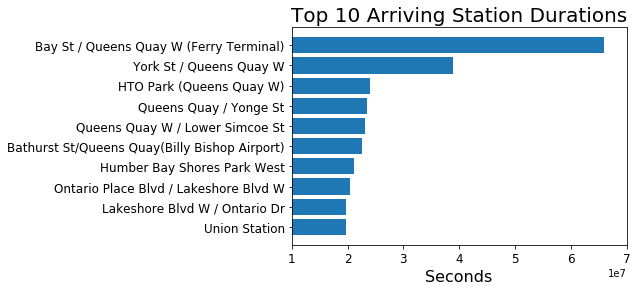

In [27]:
top_10_station_name = []
top_10_station_duration = []
for x in top_10_orders_total_duration_station:
    if not(x[0] in station_dict):
        continue
    top_10_station_name.append(station_dict[x[0]][0])
    top_10_station_duration.append(x[1])
    
top_10_station_name = top_10_station_name[::-1]
top_10_station_duration = top_10_station_duration[::-1]

print(top_10_station_name)
print(top_10_station_duration)

fig = plt.figure(8)
ax = plt.subplot(111)
ax.set_xlim([10000000, 70000000])
# fig.set_size_inches(10, 5, forward = True)
ax.barh(range(len(top_10_station_name)), top_10_station_duration, tick_label=top_10_station_name)
plt.title('Top 10 Arriving Station Durations', fontsize=20)
plt.xlabel('Seconds', fontsize=16)
plt.tick_params(axis='both', labelsize=12)
# plt.savefig("8.png")
plt.show()

In [28]:
# 2.2 each month
# 每月从哪个站点出发的订单数量最多
orders_month_from_station = []
for i in range(1, 13):
    m = 0
    orders_month_from_station_1 = []
    orders_month_from_station_temp = df.filter(df.trip_start_time.like(str(i)+'/%/2018%')) \
                                  .groupby("from_station_id") \
                                  .agg({"trip_id" : "count"}) \
                                  .sort('count(trip_id)', ascending=0) \
                                  .collect()
    
    for x in orders_month_from_station_temp:
        if m > 9:
            break
        orders_month_from_station_1.append([x['from_station_id'], x['count(trip_id)']])
        m += 1
    orders_month_from_station.append(orders_month_from_station_1)

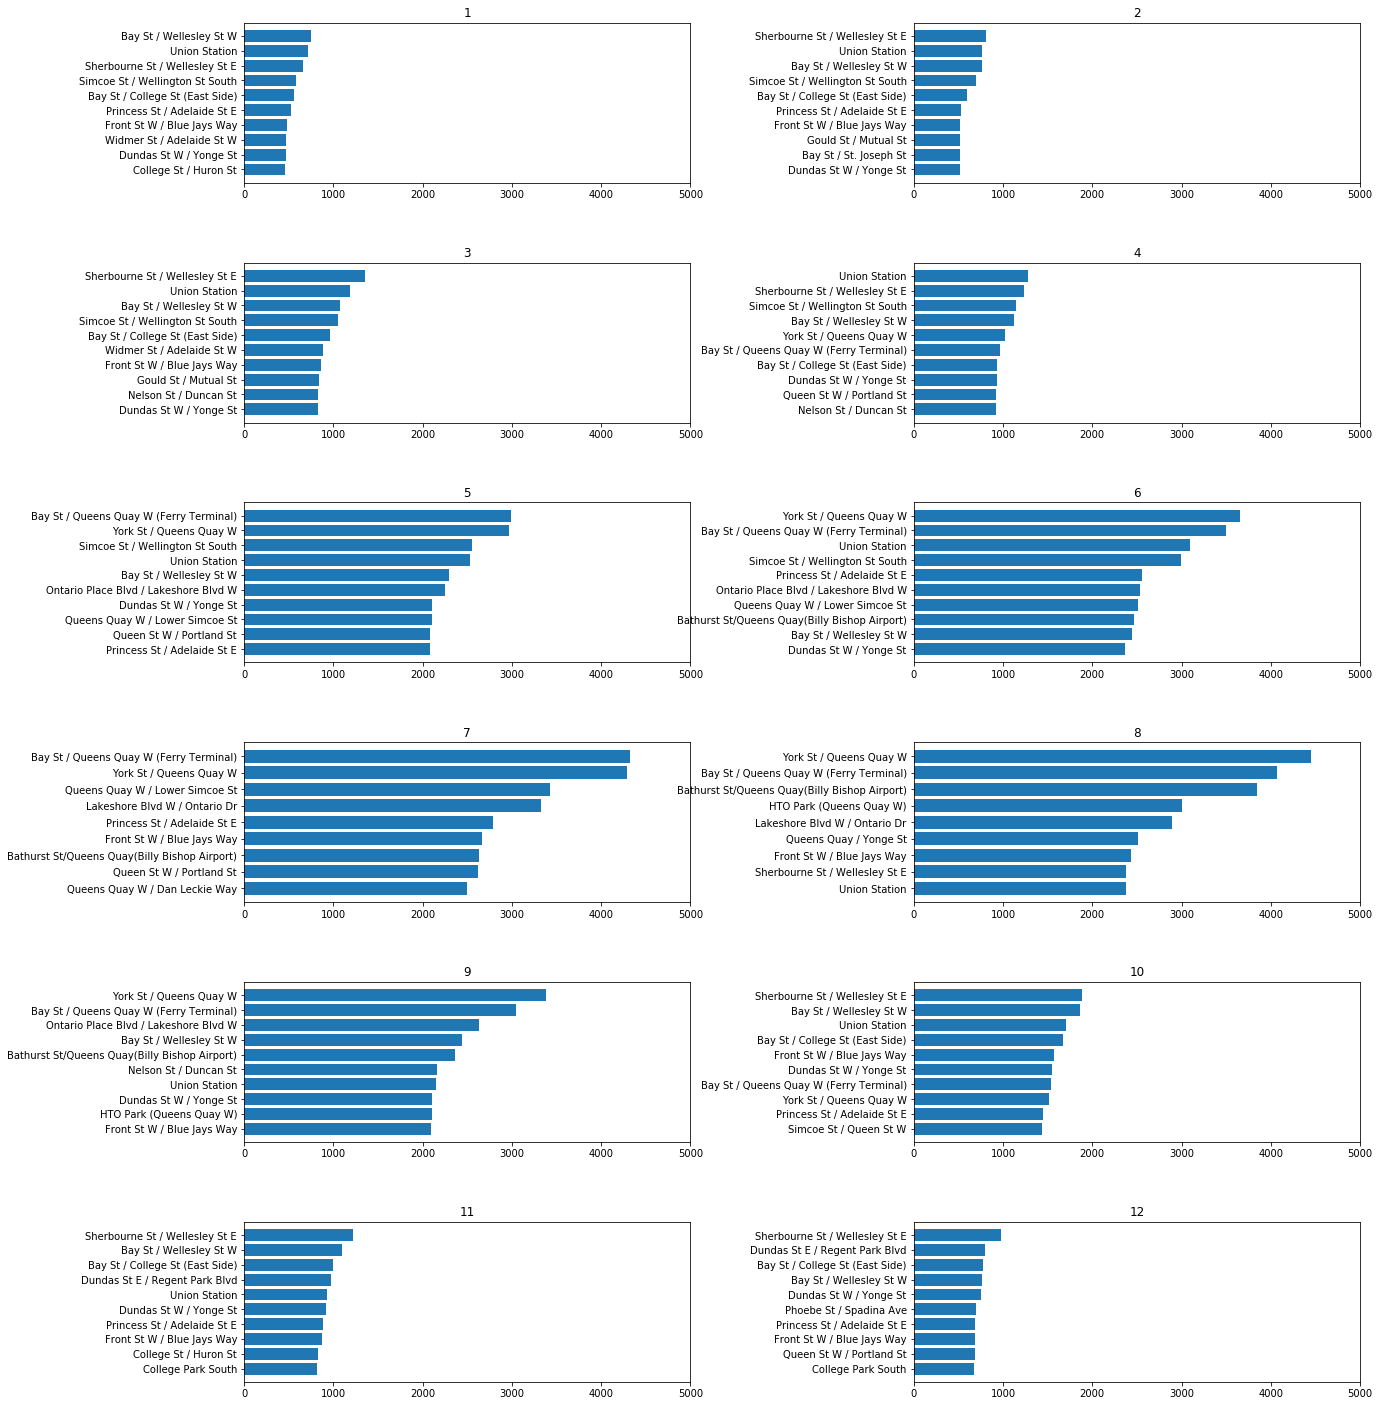

In [29]:
fig, axs = plt.subplots(6, 2, figsize=(20, 25))
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
# fig.set_size_inches(30, 20)
axs = axs.ravel()

for month in range(0, 12):
    top_10_station_name = []
    top_10_station_duration = []

    for x in orders_month_from_station[month]:
        
        if not(x[0] in station_dict):
            continue
        top_10_station_name.append(station_dict[x[0]][0])
        top_10_station_duration.append(x[1])
    
    top_10_station_name = top_10_station_name[::-1]
    top_10_station_duration = top_10_station_duration[::-1]


    axs[month].barh(range(len(top_10_station_name)), top_10_station_duration, tick_label=top_10_station_name)
    axs[month].set_title(str(month+1))
    axs[month].set_xlim([0, 5000])
# plt.savefig("9.png")
plt.show()

# 不同月份、出发站点，订单数量差异

In [30]:
# 每月到哪个站点的订单数量最多
orders_month_to_station = []
for i in range(1, 13):
    m = 0
    orders_month_to_station_1 = []
    orders_month_to_station_temp = df.filter(df.trip_start_time.like(str(i)+'/%/2018%')) \
                                  .groupby("to_station_id") \
                                  .agg({"trip_id" : "count"}) \
                                  .sort('count(trip_id)', ascending=0) \
                                  .collect()
    
    for x in orders_month_to_station_temp:
        if m > 9:
            break
        orders_month_to_station_1.append([x['to_station_id'], x['count(trip_id)']])
        m += 1
    orders_month_to_station.append(orders_month_to_station_1)

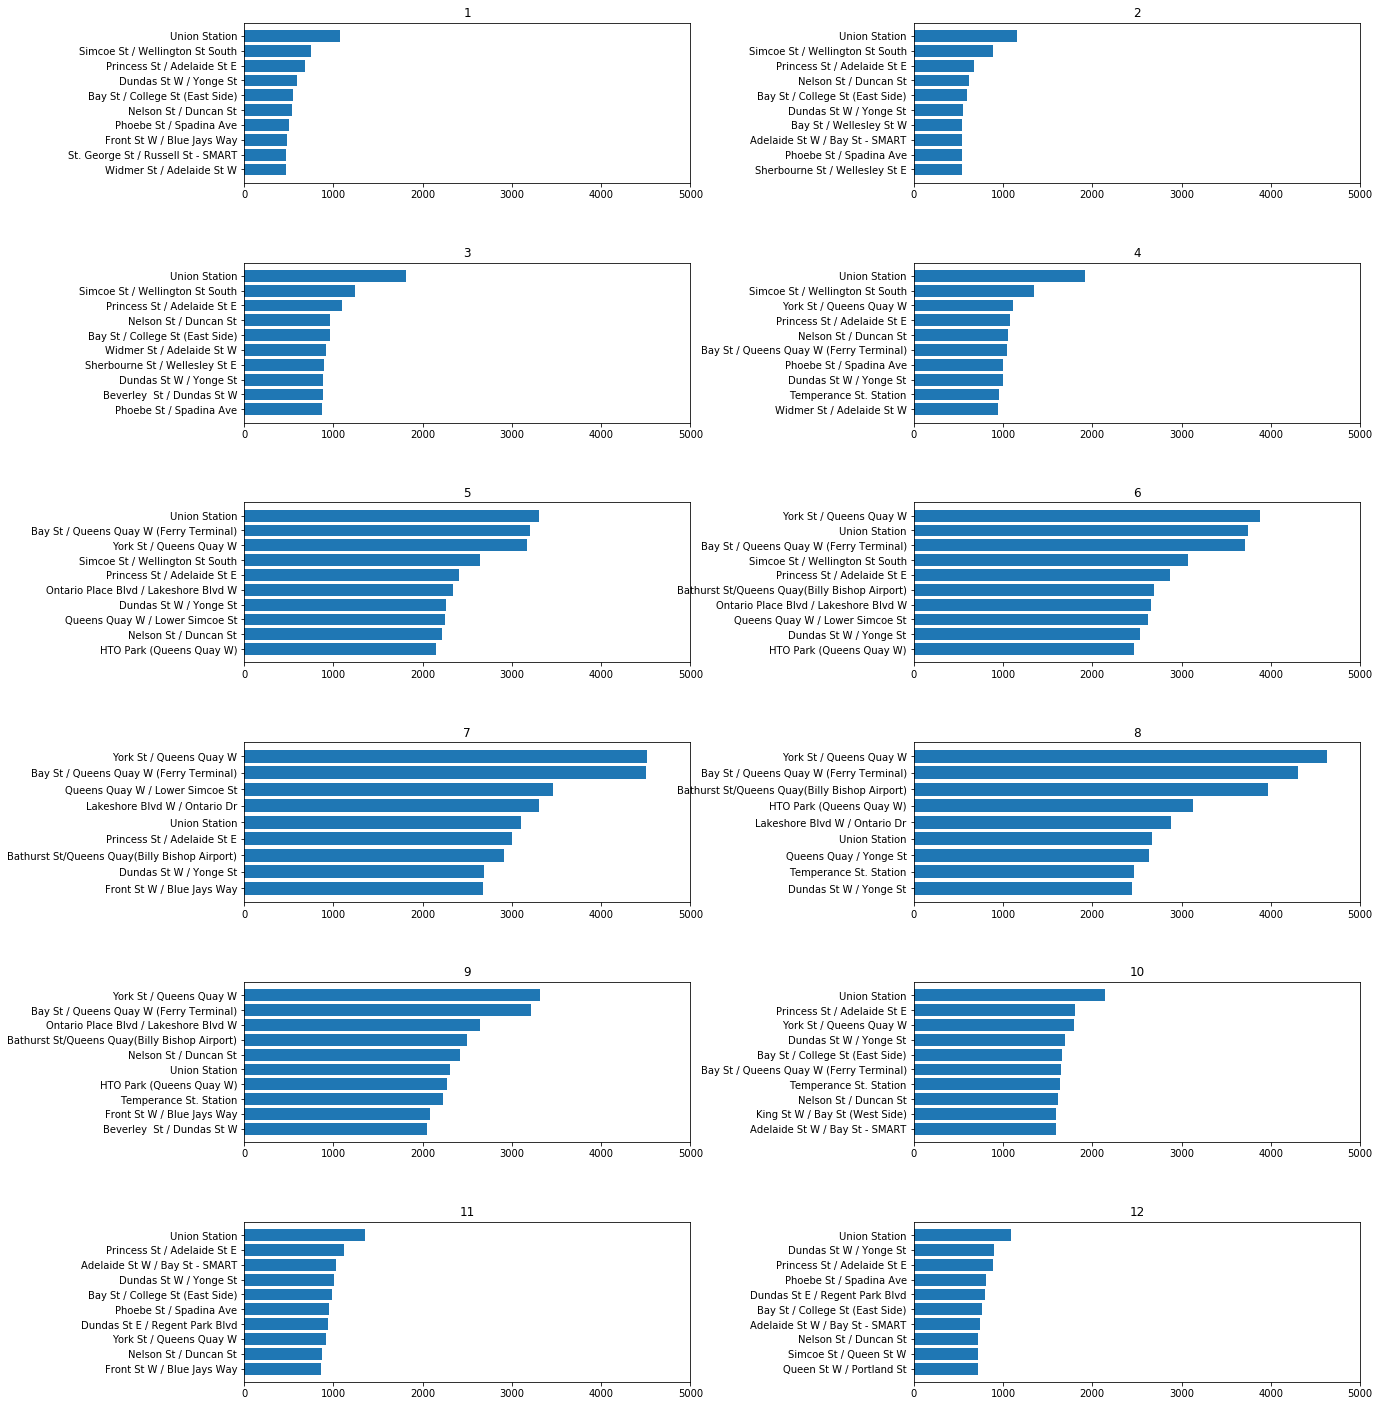

In [31]:
fig, axs = plt.subplots(6, 2, figsize=(20, 25))
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
axs = axs.ravel()

for month in range(0, 12):
    top_10_station_name = []
    top_10_station_duration = []

    for x in orders_month_to_station[month]:
        
        if not(x[0] in station_dict):
            continue
        top_10_station_name.append(station_dict[x[0]][0])
        top_10_station_duration.append(x[1])
    
    top_10_station_name = top_10_station_name[::-1]
    top_10_station_duration = top_10_station_duration[::-1]

    axs[month].barh(range(len(top_10_station_name)), top_10_station_duration, tick_label=top_10_station_name)
    axs[month].set_title(str(month+1))
    axs[month].set_xlim([0, 5000])
# plt.savefig("10.png")
plt.show()

# 不同月份，到达站点，订单差异

In [32]:
# 24 hours, which station is the most used station by users
# 每天不同时段从哪个站点出发的订单数量最多
orders_clock_from_station = []
for i in range(0, 24):
    orders_hours_from_station_1 = []
    orders_hours_from_station_temp = df.filter(df.trip_start_time.like('% '+str(i)+':%')) \
                                       .groupby("from_station_id") \
                                       .agg({"trip_id" : "count"}) \
                                       .sort('count(trip_id)', ascending=0) \
                                       .collect()
    for x in orders_hours_from_station_temp:
        orders_hours_from_station_1.append([x['from_station_id'], x['count(trip_id)']])
    orders_clock_from_station.append(orders_hours_from_station_1)

In [33]:
# 每天不同时段到哪个站点的订单数量最多
orders_clock_to_station = []
for i in range(0, 24):
    orders_hours_to_station_1 = []
    orders_hours_to_station_temp = df.filter(df.trip_start_time.like('% '+str(i)+':%')) \
                                       .groupby("to_station_id") \
                                       .agg({"trip_id" : "count"}) \
                                       .sort('count(trip_id)', ascending=0) \
                                       .collect()
    for x in orders_hours_to_station_temp:
        orders_hours_to_station_1.append([x['to_station_id'], x['count(trip_id)']])
    orders_clock_to_station.append(orders_hours_to_station_1)

In [34]:
# which from/to station has the most duration time of the whole year, month, hour
# 全年哪个站点出发骑行总时间最长
duration_year_from_station_long = []

temp = df.groupby("from_station_id") \
  .agg({"trip_duration_seconds" : "sum"})

long = temp.sort('sum(trip_duration_seconds)', ascending=0).collect()

for x in long:
    duration_year_from_station_long.append([x['from_station_id'], x['sum(trip_duration_seconds)']])
    
# print(duration_year_from_station_long)


In [35]:
top_10_station_name = []
top_10_station_duration = []
i = 1
for x in duration_year_from_station_long:
    if not(x[0] in station_dict):
        continue
    elif i>10:
        break
    top_10_station_name.append(station_dict[x[0]][0])
    top_10_station_duration.append(x[1])
    i += 1

top_10_station_name = top_10_station_name[::-1]
top_10_station_duration = top_10_station_duration[::-1]

print(top_10_station_name)
print(top_10_station_duration)

['Union Station', 'Bathurst St/Queens Quay(Billy Bishop Airport)', 'Lakeshore Blvd W / Ontario Dr', 'Ontario Place Blvd / Lakeshore Blvd W', 'Humber Bay Shores Park West', 'Queens Quay W / Lower Simcoe St', 'HTO Park (Queens Quay W)', 'Queens Quay / Yonge St', 'York St / Queens Quay W', 'Bay St / Queens Quay W (Ferry Terminal)']
[18678588, 19710711, 19748703, 19808799, 19852568, 21875397, 23034530, 24624348, 39181379, 61830593]


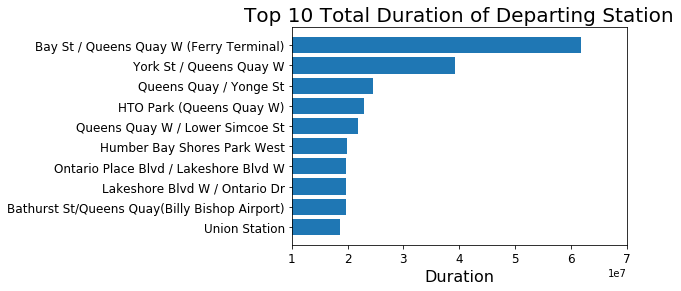

In [36]:
fig = plt.figure()
ax = plt.subplot(111)
ax.set_xlim([10000000, 70000000])
# fig.set_size_inches(10, 5, forward = True)
ax.barh(range(len(top_10_station_name)), top_10_station_duration, tick_label=top_10_station_name)
plt.title('Top 10 Total Duration of Departing Station', fontsize=20)
plt.xlabel('Duration', fontsize=16)
plt.tick_params(axis='both', labelsize=12)
# plt.savefig("11.png")
plt.show()

In [37]:
# this list contain the most and least of duration of the year
# 全年到哪个站点骑行总时间最长
duration_year_to_station = []

temp = df.groupby("to_station_id") \
  .agg({"trip_duration_seconds" : "sum"}) \
  .sort('sum(trip_duration_seconds)', ascending=0) \
  .collect()

for x in temp:
    duration_year_to_station.append([x['to_station_id'], x['sum(trip_duration_seconds)']])
    
# print(duration_year_to_station)

In [38]:
top_10_station_name = []
top_10_station_duration = []
i = 1
for x in duration_year_to_station:
    if not(x[0] in station_dict):
        continue
    elif i>10:
        break
    top_10_station_name.append(station_dict[x[0]][0])
    top_10_station_duration.append(x[1])
    i += 1

top_10_station_name = top_10_station_name[::-1]
top_10_station_duration = top_10_station_duration[::-1]

print(top_10_station_name)
print(top_10_station_duration)

['Union Station', 'Lakeshore Blvd W / Ontario Dr', 'Ontario Place Blvd / Lakeshore Blvd W', 'Humber Bay Shores Park West', 'Bathurst St/Queens Quay(Billy Bishop Airport)', 'Queens Quay W / Lower Simcoe St', 'Queens Quay / Yonge St', 'HTO Park (Queens Quay W)', 'York St / Queens Quay W', 'Bay St / Queens Quay W (Ferry Terminal)']
[19701107, 19786480, 20534068, 21206131, 22613159, 23084532, 23454925, 24019826, 38952293, 65903584]


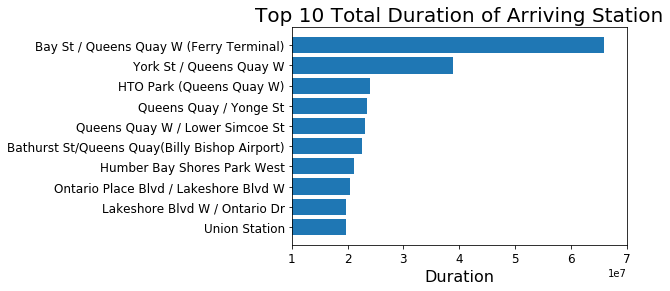

In [39]:
fig = plt.figure()
ax = plt.subplot(111)
ax.set_xlim([10000000, 70000000])
# fig.set_size_inches(10, 5, forward = True)
ax.barh(range(len(top_10_station_name)), top_10_station_duration, tick_label=top_10_station_name)
plt.title('Top 10 Total Duration of Arriving Station', fontsize=20)
plt.xlabel('Duration', fontsize=16)
plt.tick_params(axis='both', labelsize=12)
# plt.savefig("12.png")
plt.show()

In [40]:
# from_station_id == to_station_id: means user go back to return cycles, and user hang around this area
# 原站点还车的订单数量
same_station_num = df.filter(df.from_station_id == df.to_station_id).count()
print(same_station_num)
normal_orders = df.count() - same_station_num
print(normal_orders)

57267
1865688


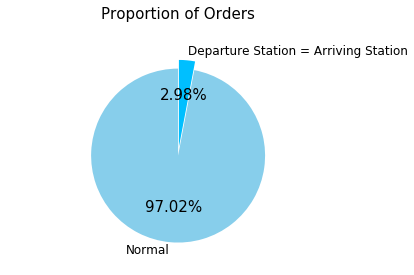

In [41]:
labels = ['Normal', 'Departure Station = Arriving Station']
sizes1 = [normal_orders, same_station_num]


explode = (0, 0.1)
colors = ['skyblue', 'deepskyblue']

fig = plt.figure()
# fig.set_size_inches(10, 8, forward = True)

ax1 = plt.subplot(111)
plt.axis('equal')
patches, text1, text2 = ax1.pie(sizes1,
                                labels = labels,
                                autopct = '%3.2f%%',
                                shadow = False,
                                startangle = 90,
                                pctdistance = 0.6,
                                explode=explode,
                                colors = colors)
for t in text1:
    t.set_size(12)
for t in text2:
    t.set_size(15)
# plt.title('Proportion of Orders', x = 0.50, y = 0.75, fontsize=16)
plt.title('Proportion of Orders', x = 0.5, y = 1.1,fontsize=15)

# plt.legend(loc = 'lower right')
# plt.savefig("13.png")
plt.show()

In [42]:
# 原站点还车站点总时间，排名（时间越多，意味着用户仅在站点周围活动）
same_station = []
temp = df.filter(df.from_station_id == df.to_station_id) \
  .groupby("from_station_id") \
  .agg({"trip_duration_seconds" : "sum"}) \
  .sort('sum(trip_duration_seconds)', ascending=0) \
  .collect()

for x in temp:
    same_station.append([x['from_station_id'], x['sum(trip_duration_seconds)']])
    
# print(same_station)

In [43]:
top_10_station_name = []
top_10_station_duration = []
i = 1
for x in same_station:
    if not(x[0] in station_dict):
        continue
    elif i>10:
        break
    top_10_station_name.append(station_dict[x[0]][0])
    top_10_station_duration.append(x[1])
    i += 1

top_10_station_name = top_10_station_name[::-1]
top_10_station_duration = top_10_station_duration[::-1]

print(top_10_station_name)
print(top_10_station_duration)

['Bloor St W / High Park Ave (High Park)', 'Ontario Place Blvd / Lakeshore Blvd W', 'HTO Park (Queens Quay W)', 'Lakeshore Blvd W / Windermere Ave', 'Lakeshore Blvd W / Ellis Ave', 'Queens Quay / Yonge St', 'Tommy Thompson Park (Leslie Street Spit)', 'Humber Bay Shores Park West', 'York St / Queens Quay W', 'Bay St / Queens Quay W (Ferry Terminal)']
[3859866, 4073209, 4869841, 5482971, 5670016, 5906884, 6978959, 7882250, 8543409, 29557872]


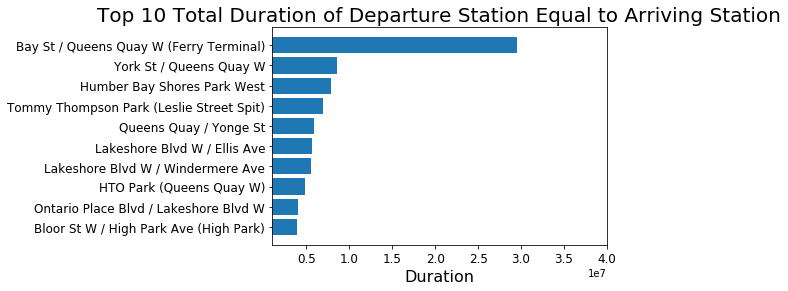

In [44]:
fig = plt.figure()
ax = plt.subplot(111)
ax.set_xlim([1000000, 40000000])
# fig.set_size_inches(10, 5, forward = True)
ax.barh(range(len(top_10_station_name)), top_10_station_duration, tick_label=top_10_station_name)
plt.title('Top 10 Total Duration of Departure Station Equal to Arriving Station', fontsize=20)
plt.xlabel('Duration', fontsize=16)
plt.tick_params(axis='both', labelsize=12)
# plt.savefig("12.png")
plt.show()

In [45]:
# 一共产生的行程线路
temp = df.withColumn("from_to", f.concat(f.col('from_station_id'), f.lit('_'), f.col('to_station_id'))) \
                .groupby("from_to") \
                .agg({'trip_id' : 'count'}) \
                .sort('count(trip_id)', ascending = 0)
            
ride_lines = temp.count()
print(ride_lines)
# temp.show()

# 热门线路统计，倒序即为冷门线路
same_route_count = []
hot_lines = temp.collect()
for x in hot_lines:
    same_route_count.append([x['from_to'], x['count(trip_id)']])
# print(same_route_count)
    

83197


In [46]:
top_10_station_name = []
top_10_station_duration = []
i = 1
for x in same_route_count:
    two_station = x[0].split('_')
    if not(two_station[0] in station_dict) or not(two_station[1] in station_dict):
        continue
    elif i>10:
        break
    if two_station[0] == two_station[1]:
        final_name = station_dict[two_station[0]][0]
    else:
        final_name = station_dict[two_station[0]][0] + '  -->  ' + station_dict[two_station[1]][0]
    top_10_station_name.append(final_name)
    top_10_station_duration.append(x[1])
    i += 1

top_10_station_name = top_10_station_name[::-1]
top_10_station_duration = top_10_station_duration[::-1]

print(top_10_station_name)
print(top_10_station_duration)

['Lakeshore Blvd W / Ellis Ave', 'HTO Park (Queens Quay W)', 'York St / Queens Quay W  -->  Bathurst St/Queens Quay(Billy Bishop Airport)', 'Tommy Thompson Park (Leslie Street Spit)', 'Ontario Place Blvd / Lakeshore Blvd W', 'Front St W / Blue Jays Way  -->  Union Station', 'Bathurst St/Queens Quay(Billy Bishop Airport)  -->  York St / Queens Quay W', 'York St / Queens Quay W', 'Humber Bay Shores Park West', 'Bay St / Queens Quay W (Ferry Terminal)']
[1562, 1606, 1617, 1742, 1746, 1955, 1964, 1969, 2162, 3515]


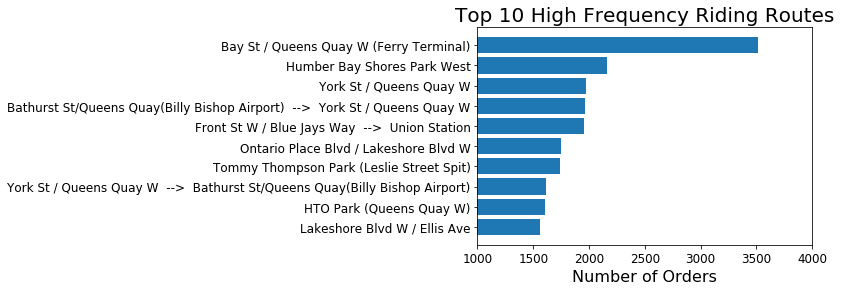

In [47]:
fig = plt.figure()
ax = plt.subplot(111)
ax.set_xlim([1000, 4000])
# fig.set_size_inches(10, 5, forward = True)
ax.barh(range(len(top_10_station_name)), top_10_station_duration, tick_label=top_10_station_name)
plt.title('Top 10 High Frequency Riding Routes', fontsize=20)
plt.xlabel('Number of Orders', fontsize=16)
plt.tick_params(axis='both', labelsize=12)
# plt.savefig("12.png")
plt.show()

In [48]:
# 三、关于会员
# 全年订单会员数量与非会员数量对比
member_count = []    # 0. Annual Member 1. cascual member

member = df.filter(df.user_type == 'Annual Member')
not_member = df.filter(df.user_type != 'Annual Member')

member_count.append(member.count())
member_count.append(not_member.count())

print(member_count)

# 全年会员骑行时间与非会员骑行时间对比
temp = member.agg({'trip_duration_seconds' : 'sum'}).collect()
member_duration = temp[0]['sum(trip_duration_seconds)']

temp = not_member.agg({'trip_duration_seconds' : 'sum'}).collect()
not_member_duration = temp[0]['sum(trip_duration_seconds)']

print(member_duration, not_member_duration)

[1572980, 349975]
1140436840 711322708


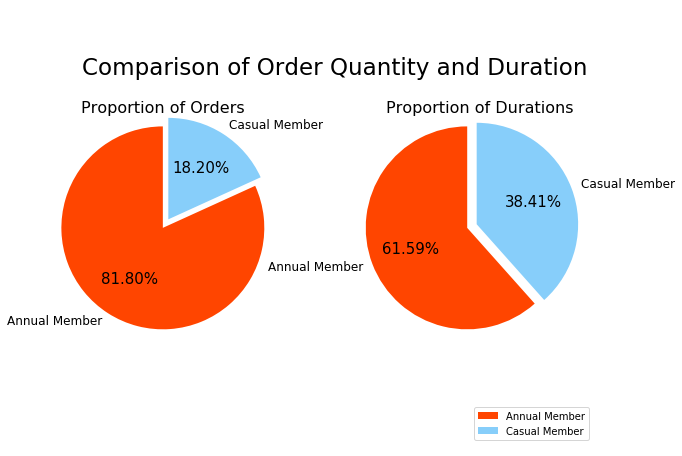

In [49]:
labels = ['Annual Member', 'Casual Member']
sizes1 = [member_count[0], member_count[1]]
sizes2 = [member_duration, not_member_duration]

explode = (0, 0.1)
colors = ['orangered', 'lightskyblue']

fig = plt.figure(3)
fig.suptitle('Comparison of Order Quantity and Duration', fontsize=23, x=0.54, y=0.8)
fig.set_size_inches(10, 8, forward = True)

ax1 = plt.subplot(121)
plt.axis('equal')
patches, text1, text2 = ax1.pie(sizes1,
                                labels = labels,
                                autopct = '%3.2f%%',
                                shadow = False,
                                startangle = 90,
                                pctdistance = 0.6,
                                explode=explode,
                                colors = colors)
for t in text1:
    t.set_size(12)
for t in text2:
    t.set_size(15)
plt.title('Proportion of Orders', x = 0.50, y = 0.75, fontsize=16)



ax2 = plt.subplot(122)
plt.axis('equal')
patches, text1, text2 = ax2.pie(sizes2,
                                labels = labels,
                                autopct = '%3.2f%%',
                                shadow = False,
                                startangle = 90,
                                pctdistance = 0.6,
                                explode=explode,
                                colors = colors)

for t in text1:
    t.set_size(12)
for t in text2:
    t.set_size(15)
plt.title('Proportion of Durations', x = 0.55, y = 0.75, fontsize=16)
plt.legend(loc = 'lower right')
# plt.savefig("14.png")
plt.show()

In [50]:
# 不同月份会员非会员骑行时间对比
month_user_type_durations = []
for i in range(1, 13):
    month_member_duration = df.filter(df.trip_start_time.like(str(i)+'/%/2018%')) \
      .groupby("user_type") \
      .agg({"trip_duration_seconds" : "sum"}) \
      .collect()
    for x in month_member_duration:
        month_user_type_durations.append(x['sum(trip_duration_seconds)'])
        
print(month_user_type_durations)

[2164234, 26521617, 4635902, 30055566, 11993180, 48988252, 28751443, 54805671, 128871625, 118616688, 138119071, 137801392, 140589726, 171716564, 135996772, 165731428, 84699443, 161277709, 25987722, 109654758, 5523762, 64609837, 3989828, 50657358]


In [51]:
month_casual_member_durations = []
month_annual_member_durations = []

for x in month_user_type_durations[1::2]:
    month_annual_member_durations.append(x)
for x in month_user_type_durations[::2]:
    month_casual_member_durations.append(x)
    
print('annual orders: ', month_annual_member_durations, 'casual orders: ', month_casual_member_durations)

annual orders:  [26521617, 30055566, 48988252, 54805671, 118616688, 137801392, 171716564, 165731428, 161277709, 109654758, 64609837, 50657358] casual orders:  [2164234, 4635902, 11993180, 28751443, 128871625, 138119071, 140589726, 135996772, 84699443, 25987722, 5523762, 3989828]


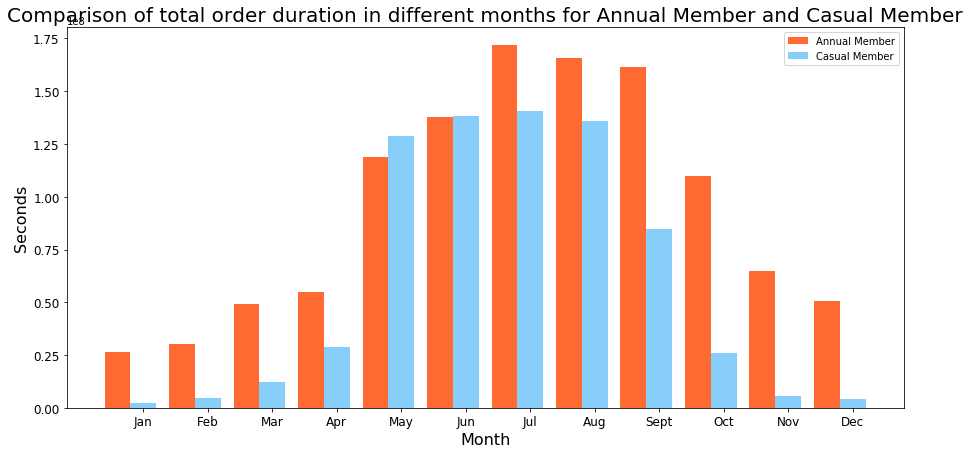

In [52]:
fig = plt.figure()
# fig.suptitle('title name here', fontsize=30)
fig.set_size_inches(15, 7, forward = True)
ax = plt.subplot(111)
x = range(len(month_annual_member_durations))

ax.bar(x,
       month_annual_member_durations,
       tick_label=month_name,
       width=0.4, alpha=0.8,
       label='Annual Member',
       color='orangered')
ax.bar([i + 0.4 for i in x],
       month_casual_member_durations,
       tick_label=month_name,
       width=0.4,
       label = 'Casual Member',
       color='lightskyblue')


plt.title('Comparison of total order duration in different months for Annual Member and Casual Member', fontsize=20)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Seconds', fontsize=16)
plt.tick_params(axis='both', labelsize=12)
plt.legend()
# plt.savefig("15.png")
plt.show()

In [53]:
# 不同时段会员与非会员骑行时间对比
hour_user_type_durations = []
for i in range(0, 24):
    hour_member_duration = df.filter(df.trip_start_time.like('% '+str(i)+':%')) \
                             .groupby("user_type") \
                             .agg({"trip_duration_seconds" : "sum"}).collect()
    for x in hour_member_duration:
        hour_user_type_durations.append(x['sum(trip_duration_seconds)'])
print(hour_user_type_durations)

[7635928, 10101961, 5280802, 6381218, 4533159, 4381766, 1865571, 2018792, 1040202, 2000452, 1131197, 4696326, 1712395, 14027834, 3832958, 42741779, 10227793, 119902336, 17342584, 73413024, 31377159, 41003853, 48121396, 45149873, 57366151, 53990806, 65185912, 55649814, 68915345, 53916234, 69748076, 62008684, 65137372, 94881630, 63672944, 142961660, 55436079, 104683327, 46860451, 69936505, 33618718, 51216229, 22241318, 39286818, 16056468, 27787692, 12982730, 18298227]


In [54]:
hour_casual_member_durations = []
hour_annual_member_durations = []

for x in hour_user_type_durations[1::2]:
    hour_annual_member_durations.append(x)
for x in hour_user_type_durations[::2]:
    hour_casual_member_durations.append(x)
    
print("annual durations: ",hour_annual_member_durations, "casual durations: ", hour_casual_member_durations)

annual durations:  [10101961, 6381218, 4381766, 2018792, 2000452, 4696326, 14027834, 42741779, 119902336, 73413024, 41003853, 45149873, 53990806, 55649814, 53916234, 62008684, 94881630, 142961660, 104683327, 69936505, 51216229, 39286818, 27787692, 18298227] casual durations:  [7635928, 5280802, 4533159, 1865571, 1040202, 1131197, 1712395, 3832958, 10227793, 17342584, 31377159, 48121396, 57366151, 65185912, 68915345, 69748076, 65137372, 63672944, 55436079, 46860451, 33618718, 22241318, 16056468, 12982730]


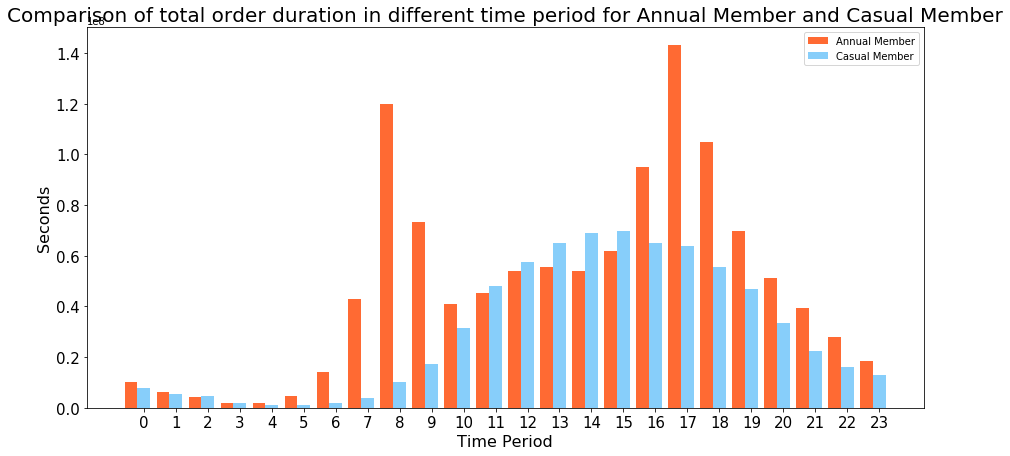

In [55]:
fig = plt.figure()
# fig.suptitle('title name here', fontsize=30)
fig.set_size_inches(15, 7, forward = True)
ax = plt.subplot(111)
x = range(len(hour_annual_member_durations))

ax.bar(x,
       hour_annual_member_durations,
       tick_label=hour_name,
       width=0.4, alpha=0.8,
       label='Annual Member',
       color='orangered')
ax.bar([i + 0.4 for i in x],
       hour_casual_member_durations,
       tick_label=hour_name,
       width=0.4,
       label = 'Casual Member',
       color='lightskyblue')


plt.title('Comparison of total order duration in different time period for Annual Member and Casual Member', fontsize=20)
plt.xlabel('Time Period', fontsize=16)
plt.ylabel('Seconds', fontsize=16)
plt.tick_params(axis='both', labelsize=15)
plt.legend()
# plt.savefig("16.png")
plt.show()

In [56]:
# 不同月份、时段会员订单与非会员订单数量对比
# for i in range(1, 13)
month_user_type_orders = []    # [[member[month]][[not_member[month]]]]
for i in range(1, 13):
    month_member = df.filter(df.trip_start_time.like(str(i)+'/%/2018%')) \
                     .groupby("user_type") \
                     .agg({"trip_id" : "count"}).collect()

    for x in month_member:
#         print(x['user_type'], x['count(trip_id)'])
        month_user_type_orders.append(x['count(trip_id)'])
#         print('-----------------')
print(month_user_type_orders)

month_casual_member_orders = []
month_annual_member_orders = []

for x in month_user_type_orders[1::2]:
    month_annual_member_orders.append(x)
for x in month_user_type_orders[::2]:
    month_casual_member_orders.append(x)
    
print("annual orders: ",month_annual_member_orders, "casual orders: ", month_casual_member_orders)

[1390, 42469, 2455, 47276, 6405, 78564, 12589, 82194, 51761, 160989, 64374, 186463, 70481, 215835, 71449, 209770, 47212, 207789, 15553, 160326, 3612, 100675, 2694, 80630]
annual orders:  [42469, 47276, 78564, 82194, 160989, 186463, 215835, 209770, 207789, 160326, 100675, 80630] casual orders:  [1390, 2455, 6405, 12589, 51761, 64374, 70481, 71449, 47212, 15553, 3612, 2694]


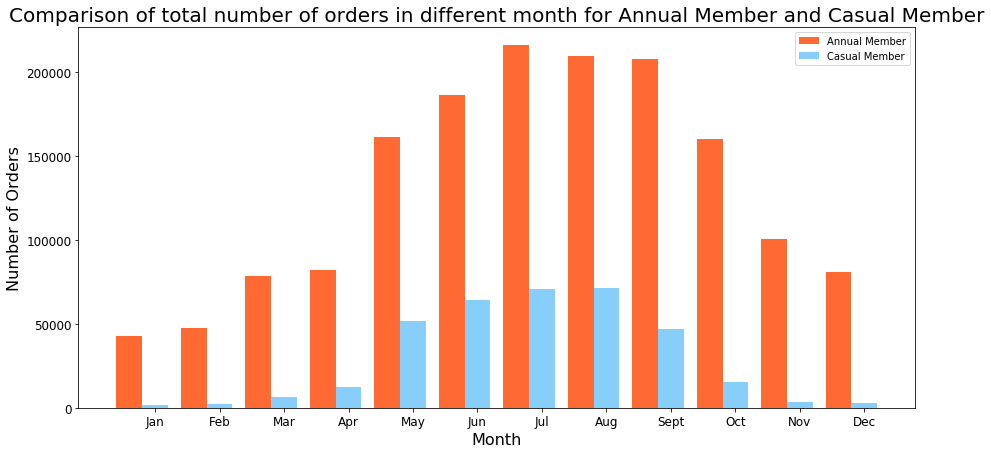

In [57]:
fig = plt.figure()
# fig.suptitle('title name here', fontsize=30)
fig.set_size_inches(15, 7, forward = True)
ax = plt.subplot(111)
x = range(len(month_annual_member_orders))

ax.bar(x,
       month_annual_member_orders,
       tick_label=month_name,
       width=0.4, alpha=0.8,
       label='Annual Member',
       color='orangered')
ax.bar([i + 0.4 for i in x],
       month_casual_member_orders,
       tick_label=month_name,
       width=0.4,
       label = 'Casual Member',
       color='lightskyblue')


plt.title('Comparison of total number of orders in different month for Annual Member and Casual Member', fontsize=20)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Number of Orders', fontsize=16)
plt.tick_params(axis='both', labelsize=12)
plt.legend()
# plt.savefig("17.png")
plt.show()

In [58]:
hour_user_type_orders = []
for i in range(0, 24):
    hour_member = df.filter(df.trip_start_time.like('% '+str(i)+':%')) \
                    .groupby("user_type") \
                    .agg({"trip_id" : "count"}).collect()
    for x in hour_member:
        hour_user_type_orders.append(x['count(trip_id)'])
        
print(hour_user_type_orders)

[4305, 14805, 2903, 9119, 2406, 6351, 1001, 2918, 597, 2614, 633, 7089, 1149, 21374, 2564, 61434, 7069, 165555, 8781, 110869, 13441, 59246, 20240, 62260, 24669, 77559, 27593, 77354, 29809, 71783, 30856, 83641, 31499, 128480, 33509, 188356, 29861, 139222, 25660, 94046, 19539, 69699, 13838, 53842, 10186, 38964, 7867, 26400]


In [59]:
hour_casual_member_orders = []
hour_annual_member_orders = []

for x in hour_user_type_orders[::2]:
    hour_casual_member_orders.append(x)
for x in hour_user_type_orders[1::2]:
    hour_annual_member_orders.append(x)

print("hour annual orders: ", hour_annual_member_orders)
print("hour casual orders: ", hour_casual_member_orders)

hour annual orders:  [14805, 9119, 6351, 2918, 2614, 7089, 21374, 61434, 165555, 110869, 59246, 62260, 77559, 77354, 71783, 83641, 128480, 188356, 139222, 94046, 69699, 53842, 38964, 26400]
hour casual orders:  [4305, 2903, 2406, 1001, 597, 633, 1149, 2564, 7069, 8781, 13441, 20240, 24669, 27593, 29809, 30856, 31499, 33509, 29861, 25660, 19539, 13838, 10186, 7867]


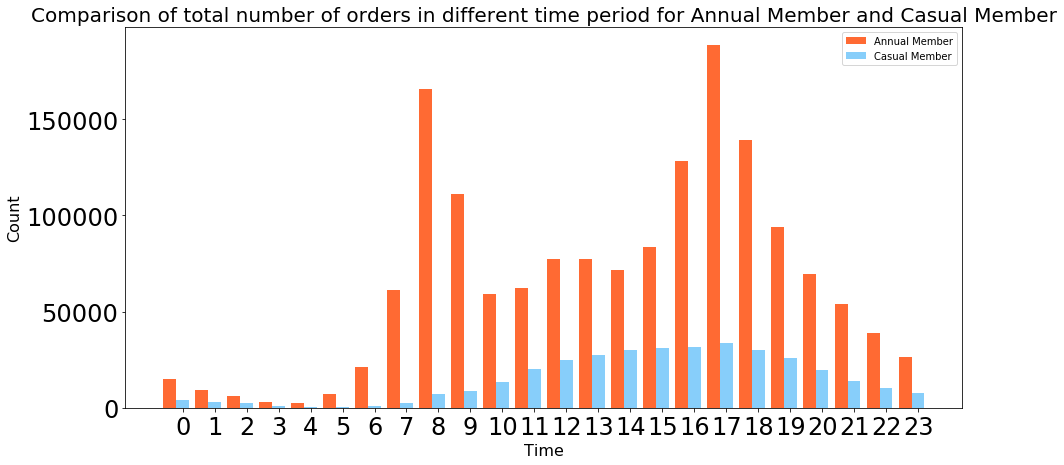

In [60]:
fig = plt.figure()
# fig.suptitle('title name here', fontsize=30)
fig.set_size_inches(15, 7, forward = True)
ax = plt.subplot(111)
x = range(len(hour_annual_member_orders))

ax.bar(x,
       hour_annual_member_orders,
       tick_label=hour_name,
       width=0.4, alpha=0.8,
       label='Annual Member',
       color='orangered')
ax.bar([i + 0.4 for i in x],
       hour_casual_member_orders,
       tick_label=hour_name,
       width=0.4,
       label = 'Casual Member',
       color='lightskyblue')


plt.title('Comparison of total number of orders in different time period for Annual Member and Casual Member', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.tick_params(axis='both', labelsize=24)
plt.legend()
# plt.savefig("18.png")
plt.show()

In [61]:
# 会员出行热门线路
temp = df.withColumn("from_to", f.concat(f.col('from_station_id'), f.lit('_'), f.col('to_station_id'))) \
                .filter(df.user_type == 'Annual Member') \
                .groupby("from_to") \
                .agg({'trip_id' : 'count'}) \
                .sort('count(trip_id)', ascending = 0) \
                .collect()

In [62]:
hot_line_member_list = []

for x in temp:
    hot_line_member_list.append([x[0], x[1]])

# print(hot_line_member_list)

In [63]:
top_10_station_name = []
top_10_station_duration = []
i = 1
for x in hot_line_member_list:
    two_station = x[0].split('_')
    if not(two_station[0] in station_dict) or not(two_station[1] in station_dict):
        continue
    elif i>10:
        break
    if two_station[0] == two_station[1]:
        final_name = station_dict[two_station[0]][0]
    else:
        final_name = station_dict[two_station[0]][0] + '  -->  ' + station_dict[two_station[1]][0]
    top_10_station_name.append(final_name)
    top_10_station_duration.append(x[1])
    i += 1

top_10_station_name = top_10_station_name[::-1]
top_10_station_duration = top_10_station_duration[::-1]

print(top_10_station_name)
print(top_10_station_duration)

['Front St W / Blue Jays Way  -->  King St W / Bay St (East Side)', 'Union Station  -->  Front St W / Blue Jays Way', 'Queen St W / Portland St  -->  Niagara St / Richmond St W', 'Fort York  Blvd / Capreol Ct  -->  Union Station', 'Sherbourne St / Wellesley St E  -->  Wellesley St E / Yonge St (Green P)', 'Bay St / Wellesley St W  -->  Union Station', 'Wellesley St E / Yonge St (Green P)  -->  Sherbourne St / Wellesley St E', 'York St / Queens Quay W  -->  Bathurst St/Queens Quay(Billy Bishop Airport)', 'Bathurst St/Queens Quay(Billy Bishop Airport)  -->  York St / Queens Quay W', 'Front St W / Blue Jays Way  -->  Union Station']
[702, 709, 734, 750, 773, 823, 1154, 1329, 1555, 1886]


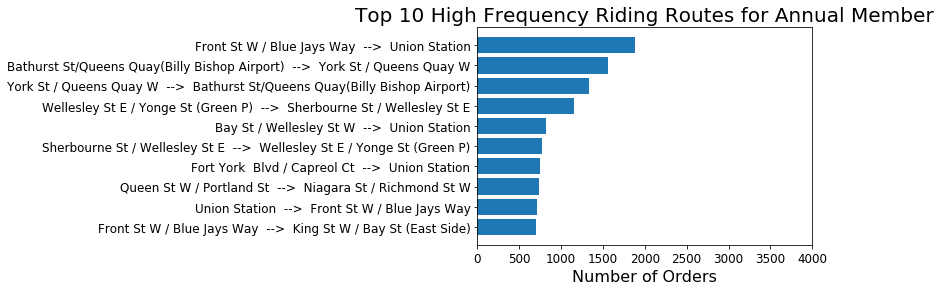

In [64]:
fig = plt.figure()
ax = plt.subplot(111)
ax.set_xlim([0, 4000])
# fig.set_size_inches(10, 5, forward = True)
ax.barh(range(len(top_10_station_name)), top_10_station_duration, tick_label=top_10_station_name)
plt.title('Top 10 High Frequency Riding Routes for Annual Member', fontsize=20)
plt.xlabel('Number of Orders', fontsize=16)
plt.tick_params(axis='both', labelsize=12)
# plt.savefig("12.png")
plt.show()

In [65]:
# 非会员出行热门线路
temp = df.withColumn("from_to", f.concat(f.col('from_station_id'), f.lit('_'), f.col('to_station_id'))) \
                .filter(df.user_type == 'Casual Member') \
                .groupby("from_to") \
                .agg({'trip_id' : 'count'}) \
                .sort('count(trip_id)', ascending = 0) \
                .collect()

In [66]:
hot_line_member_list = []

for x in temp:
    hot_line_member_list.append([x[0], x[1]])

# print(hot_line_member_list)

In [67]:
top_10_station_name = []
top_10_station_duration = []
i = 1
for x in hot_line_member_list:
    two_station = x[0].split('_')
    if not(two_station[0] in station_dict) or not(two_station[1] in station_dict):
        continue
    elif i>10:
        break
    if two_station[0] == two_station[1]:
        final_name = station_dict[two_station[0]][0]
    else:
        final_name = station_dict[two_station[0]][0] + '  -->  ' + station_dict[two_station[1]][0]
    top_10_station_name.append(final_name)
    top_10_station_duration.append(x[1])
    i += 1

top_10_station_name = top_10_station_name[::-1]
top_10_station_duration = top_10_station_duration[::-1]

print(top_10_station_name)
print(top_10_station_duration)

['Lakeshore Blvd W / Ontario Dr  -->  Sunnyside - Gus Ryder Pool', 'Lakeshore Blvd W / Ontario Dr', 'Lakeshore Blvd W / Windermere Ave', 'Ontario Place Blvd / Lakeshore Blvd W', 'HTO Park (Queens Quay W)', 'Lakeshore Blvd W / Ellis Ave', 'Tommy Thompson Park (Leslie Street Spit)', 'York St / Queens Quay W', 'Humber Bay Shores Park West', 'Bay St / Queens Quay W (Ferry Terminal)']
[852, 929, 1097, 1168, 1283, 1403, 1417, 1581, 1815, 2978]


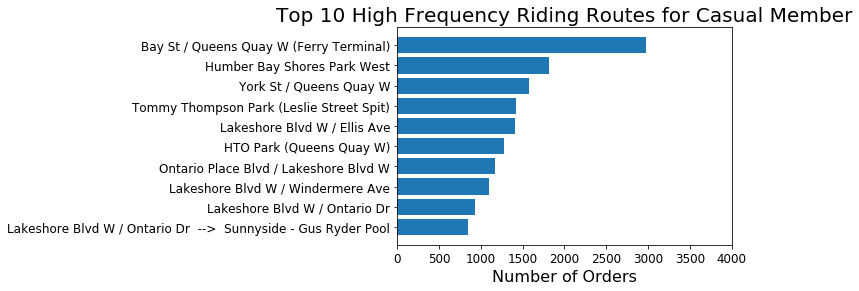

In [68]:
fig = plt.figure()
ax = plt.subplot(111)
ax.set_xlim([0, 4000])
# fig.set_size_inches(10, 5, forward = True)
ax.barh(range(len(top_10_station_name)), top_10_station_duration, tick_label=top_10_station_name)
plt.title('Top 10 High Frequency Riding Routes for Casual Member', fontsize=20)
plt.xlabel('Number of Orders', fontsize=16)
plt.tick_params(axis='both', labelsize=12)
# plt.savefig("12.png")
plt.show()